# Import Module

In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn

from src.core.utils import describe

## build data loader

In [2]:
from src.datasets.loader.build_loader import build_dataloader
from mmcv.utils.config import Config


cfg = Config.fromfile('config/retinanet_x101_64x4d_fpn_1x.py')

train_cfg = cfg.train_cfg
test_cfg = cfg.test_cfg
dataset_cfg = cfg.data.val

loader = iter(build_dataloader(dataset_cfg))

loading annotations into memory...
Done (t=0.31s)
creating index...
index created!


## Build Module

### feature extractor :  backbone + neck

In [3]:
"""
backbone=dict(
        type='ResNeXt',
        depth=101,
        groups=64,
        base_width=4,
        num_stages=4,
        out_indices=(0, 1, 2, 3),
        frozen_stages=1,
        style='pytorch'),
neck=dict(
        type='FPN',
        in_channels=[256, 512, 1024, 2048],
        out_channels=256,
        start_level=1,
        add_extra_convs=True,
        num_outs=5)
"""
from src.models.builder import build_backbone, build_neck


class FeatureExtractor(nn.Module):
    def __init__(self, cfg):
        super(FeatureExtractor, self).__init__()
        backbone_cfg = cfg.model.backbone
        neck_cfg = cfg.model.neck
        
        self.backbone = build_backbone(backbone_cfg)
        self.neck = build_neck(neck_cfg)
    
    def forward(self, x):
        print(f"Raw Image shape : {describe(x)}")
        
        feature = self.backbone(x)
        print(f"After Resnext Passed: {describe(feature)}")
        
        multi_level_feature = self.neck(feature)
        print(f"After FPN Passed: {describe(multi_level_feature)}")
        
        return multi_level_feature

### Head : RetinaHead

In [4]:
"""
bbox_head=dict(
    type='RetinaHead',
    num_classes=81,  # background + 80 (RetinaNet)
    in_channels=256, # (RetinaNet)
    stacked_convs=4,  # number of class/box subnet's conv layers (RetinaNet)
    feat_channels=256,  # num_channels in subnet's conv feature (RetinaNet)
    octave_base_scale=4,  # anchor scale related factor (RetinaNet)
    scales_per_octave=3,  # anchor scale related factor (RetinaNet)
    anchor_ratios=[0.5, 1.0, 2.0],  # anchor scale related factor (RetinaNet)
    anchor_strides=[8, 16, 32, 64, 128],  # stride of anchor, normally stride of feature map. (RetinaNet)
    target_means=[.0, .0, .0, .0],  # regression target mean (RetinaNet)
    target_stds=[1.0, 1.0, 1.0, 1.0]))  # regression target std (RetinaNet)
"""
from src.models.builder import build_head


class Head(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.bbox_head = build_head(cfg.model.bbox_head)
    
    def forward(self, feature):
        cls_score, bbox_pred = self.bbox_head(feature)
        return cls_score, bbox_pred

## Load pretrained checkpoint

In [5]:
from mmcv.runner import load_checkpoint


feature_extractor = FeatureExtractor(cfg)
_ = load_checkpoint(feature_extractor, 'pretrained/retinanet_x101_64x4d_fpn_1x_pretrained.pth')

bbox_head = Head(cfg)
_ = load_checkpoint(bbox_head, 'pretrained/retinanet_x101_64x4d_fpn_1x_pretrained.pth')

unexpected key in source state_dict: bbox_head.cls_convs.0.conv.weight, bbox_head.cls_convs.0.conv.bias, bbox_head.cls_convs.1.conv.weight, bbox_head.cls_convs.1.conv.bias, bbox_head.cls_convs.2.conv.weight, bbox_head.cls_convs.2.conv.bias, bbox_head.cls_convs.3.conv.weight, bbox_head.cls_convs.3.conv.bias, bbox_head.reg_convs.0.conv.weight, bbox_head.reg_convs.0.conv.bias, bbox_head.reg_convs.1.conv.weight, bbox_head.reg_convs.1.conv.bias, bbox_head.reg_convs.2.conv.weight, bbox_head.reg_convs.2.conv.bias, bbox_head.reg_convs.3.conv.weight, bbox_head.reg_convs.3.conv.bias, bbox_head.retina_cls.weight, bbox_head.retina_cls.bias, bbox_head.retina_reg.weight, bbox_head.retina_reg.bias

unexpected key in source state_dict: backbone.conv1.weight, backbone.bn1.weight, backbone.bn1.bias, backbone.bn1.running_mean, backbone.bn1.running_var, backbone.bn1.num_batches_tracked, backbone.layer1.0.conv1.weight, backbone.layer1.0.bn1.weight, backbone.layer1.0.bn1.bias, backbone.layer1.0.bn1.running_

### Load data

In [6]:
sample = next(loader)
print(sample.keys())

img = sample['img'].data[0]
img_metas = sample['img_meta'].data[0]
gt_bboxes = sample['gt_bboxes'].data[0]
gt_labels = sample['gt_labels'].data[0]

dict_keys(['img', 'img_meta', 'gt_bboxes', 'gt_labels'])


### feature extraction

In [7]:
feature = feature_extractor(img)
"""
image로부터 deep feature를 얻는 과정입니다.
FPN을 거쳐서 multi level feature가 되므로 형태는 level개수만큼의 길이를 가진 list에 
각 원소로 [batch, channel, h, w]크기를 갖는 tensor를 갖도록 만들어집니다.
"""
print(describe(feature))

Raw Image shape : torch.Size([1, 3, 608, 928])
After Resnext Passed: [torch.Size([1, 256, 152, 232]), torch.Size([1, 512, 76, 116]), torch.Size([1, 1024, 38, 58]), torch.Size([1, 2048, 19, 29])]
After FPN Passed: [torch.Size([1, 256, 76, 116]), torch.Size([1, 256, 38, 58]), torch.Size([1, 256, 19, 29]), torch.Size([1, 256, 10, 15]), torch.Size([1, 256, 5, 8])]
[torch.Size([1, 256, 76, 116]), torch.Size([1, 256, 38, 58]), torch.Size([1, 256, 19, 29]), torch.Size([1, 256, 10, 15]), torch.Size([1, 256, 5, 8])]


### bbox prediction

In [8]:
cls_score, bbox_pred = bbox_head(feature)
"""
multi level feature를 bbox_head에 통과시킵니다.
각 level별로 forward를 한 번 씩 수행하고 결과를 다시 list형태로 되돌려줍니다.
"""
print(describe(cls_score))
print(describe(bbox_pred))

[torch.Size([1, 720, 76, 116]), torch.Size([1, 720, 38, 58]), torch.Size([1, 720, 19, 29]), torch.Size([1, 720, 10, 15]), torch.Size([1, 720, 5, 8])]
[torch.Size([1, 36, 76, 116]), torch.Size([1, 36, 38, 58]), torch.Size([1, 36, 19, 29]), torch.Size([1, 36, 10, 15]), torch.Size([1, 36, 5, 8])]


## Calculate losses

### define anchor_generators

In [9]:
bbox_head.bbox_head.init_anchor_generator()

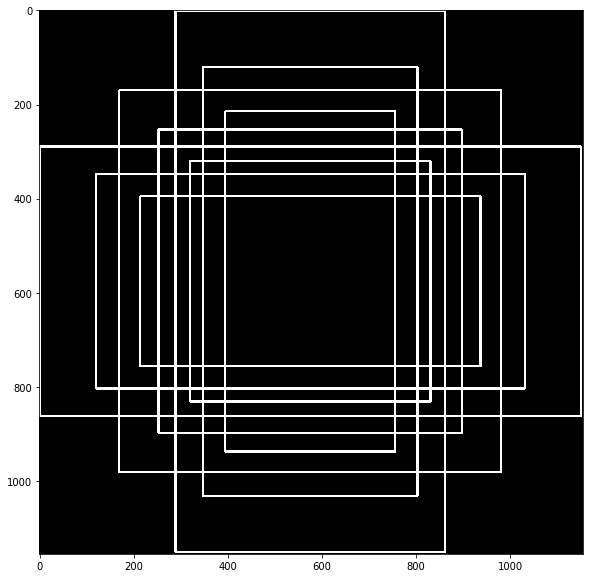

In [10]:
from src.visualization.visualize import draw_base_anchor
"""
level별 anchor_generator에서 가지고 있는 base_anchor가 실제로 어떻게 구성되는지 보여드리는 부분입니다.
line_size를 적절히 조절하며 확인해보세요.
"""


draw_base_anchor(bbox_head.bbox_head.anchor_generators[4], line_size=3)

### get anchors

In [11]:
from src.quiz.quiz1 import get_anchors
"""
anchor에 대한 규칙을 통해 실제 feature map위에 anchor를 그립니다.
feature map의 적절한 위치에 anchor가 그려지는지 여부를 확인해서 valid_flag로 관리합니다.
엉뚱한 위치에 anchor를 그리지 않기 위함입니다.
"""

featmap_sizes = [featmap.size()[-2:] for featmap in cls_score]
anchor_list, valid_flag_list = get_anchors(bbox_head.bbox_head.anchor_generators, bbox_head.bbox_head.anchor_strides, featmap_sizes, img_metas)

In [12]:
describe(anchor_list)

[[torch.Size([79344, 4]),
  torch.Size([19836, 4]),
  torch.Size([4959, 4]),
  torch.Size([1350, 4]),
  torch.Size([360, 4])]]

In [13]:
describe(valid_flag_list)

[[torch.Size([79344]),
  torch.Size([19836]),
  torch.Size([4959]),
  torch.Size([1350]),
  torch.Size([360])]]

### Make Target

### anchor_target_single

In [14]:
num_imgs = len(img_metas)
assert len(anchor_list) == len(valid_flag_list) == num_imgs

num_level_anchors = [anchors.size(0) for anchors in anchor_list[0]]

for i in range(num_imgs):
    assert len(anchor_list[i]) == len(valid_flag_list[i])
    anchor_list[i] = torch.cat(anchor_list[i])
    valid_flag_list[i] = torch.cat(valid_flag_list[i])

In [15]:
"""
여러 장의 이미지로 이루어진 배치에서 각 이미지에 대해서 동작하는 모습을 보여주는 부분입니다. 
현재 배치 크기는 1을 가정하고 진행하였습니다.
"""

"""
현재 call에서 처리하는 이미지에 대한 정보를 가져옵니다.
"""
flat_anchors = anchor_list[0]
valid_flags = valid_flag_list[0]
gt_bbox = gt_bboxes[0]
gt_label = gt_labels[0]
img_meta = img_metas[0]
label_channels = bbox_head.bbox_head.cls_out_channels


from src.quiz.quiz6 import anchor_inside_flags

"""
모든 anchor box에 대하여 각 모서리가 모두 이미지 영역 안에 들어오는지를 확인합니다.
논문 구현에 따라서 모든 모서리가 이미지 내에 존재해야만 학습에 사용하는 경우도 있고,
반대로 이미지 영역을 벗어나더라도 학습에 사용하는 경우도 있으니
논문을 읽으실 때 위 내용에 주의를 기울여 보세요.
"""
inside_flags = anchor_inside_flags(flat_anchors, valid_flags,
                                   img_meta['img_shape'][:2],
                                   train_cfg.allowed_border)
anchors = flat_anchors[inside_flags, :]

In [16]:
"""
anchor box를 positive sample / negative sample로 분할하는 작업입니다.
label의 기준을 설정하는 과정이 녹아있는 부분이므로
꼭 코드를 통해서 assign과정을 확인하시길 강력하게 추천드립니다.
"""
from src.quiz.quiz11 import assign


assign_result = assign(anchors, gt_bbox, train_cfg.assigner)

* 튜토리얼중에 아래 내용과 관련하여 중요한 오류를 전달드린 부분이 있어서 정정드립니다.
* 오류 : RetinaNet은 negative sample을 학습에 사용하지 않습니다.
* 정정 : RetinaNet은 모든 anchor box에 대하여 loss를 계산합니다.(학습에 사용합니다)
    * 다만 Negative sample의 경우 focal loss적용 과정에서 weight가 무시할 만큼 작은 크기로 변하게 되고,
      따라서 loss의 normalize할 때에는 유의미한 loss를 주는 positive sample의 개수만을 사용합니다.
* 요약 : 학습에는 positive/negative sample을 사용, loss term의 normalize에는 positive sample만을 사용

In [17]:
"""
RetinaNet은 모든 anchor를 학습에 사용하므로 Sampling을 진행하지 않습니다.
MMDetection은 Sampling을 사용하는 타 모델과 RetinaNet을 함께 구현하기 위하여 PseudoSampler 클래스를 사용합니다.
해당 클래스를 통해 Sampling을 진행한 것과 같은 형식으로 만들 수 있습니다.
"""
from src.core.bbox import PseudoSampler


bbox_sampler = PseudoSampler()
sampling_result = bbox_sampler.sample(assign_result, anchors, gt_bbox)

In [18]:
"""
Sampling한 결과물을 학습에 사용할 target형태로 만들어주는 작업입니다.

첫 번째 단계에서는 모든 anchor에서 target을 계산할 수 있다는 가정 하에
bbox_targets를 anchors와 같게,
labels를 anchor의 개수와 같게 만들고
값을 모두 0으로 초기화 합니다.(torch.zeros)
"""
num_valid_anchors = anchors.shape[0]
bbox_targets = torch.zeros_like(anchors)
bbox_weights = torch.zeros_like(anchors)
labels = anchors.new_zeros(num_valid_anchors, dtype=torch.long)
label_weights = anchors.new_zeros(num_valid_anchors, dtype=torch.float)

In [19]:
"""
두 번째 단계는 target에 적절한 값을 대입해주는 작업입니다.
학습에 사용할 anchor의 index를 pos_inds, neg_inds에서 각각 가져옵니다.
해당 anchor들을 delta 형태로 고친 다음, targets에 넣습니다.
"""
from src.core.anchor import unmap, expand_binary_labels
from src.quiz.quiz7 import bbox2delta

pos_inds = sampling_result.pos_inds
neg_inds = sampling_result.neg_inds

if len(pos_inds) > 0:
    pos_bbox_targets = bbox2delta(sampling_result.pos_bboxes,
                                  sampling_result.pos_gt_bboxes)
    bbox_targets[pos_inds, :] = pos_bbox_targets
    bbox_weights[pos_inds, :] = 1.0

    labels[pos_inds] = gt_label[sampling_result.pos_assigned_gt_inds]
    label_weights[pos_inds] = 1.0

"""
Negative sample의 class id는 0이고 이미 pos_inds를 제외한 부분이 0으로 되어있으므로
weight만 수정해줍니다.
"""
if len(neg_inds) > 0:
    label_weights[neg_inds] = 1.0

"""
처음 만들었던 flat_anchors와 같은 모양으로 복구하기 위하여
inside_flag로 제외했던 anchor에 대한 target을 추가합니다.
학습에 사용되지 않으므로 모두 0으로 채우게 됩니다.
"""

num_total_anchors = flat_anchors.size(0)
labels = unmap(labels, num_total_anchors, inside_flags)
label_weights = unmap(label_weights, num_total_anchors, inside_flags)
if label_channels > 1:
    labels, label_weights = expand_binary_labels(
            labels, label_weights, label_channels)
bbox_targets = unmap(bbox_targets, num_total_anchors, inside_flags)
bbox_weights = unmap(bbox_weights, num_total_anchors, inside_flags)

describe((labels, label_weights, bbox_targets, bbox_weights, pos_inds,
        neg_inds))

[torch.Size([105849, 80]),
 torch.Size([105849, 80]),
 torch.Size([105849, 4]),
 torch.Size([105849, 4]),
 torch.Size([372]),
 torch.Size([104889])]

### anchor_target

In [20]:
"""
anchor_target_single에서 길게 설명한 코드를 각 이미지에 대하여 한꺼번에 연산하는 부분입니다.
multi_apply라는 유용한 함수를 통해 단 한 번의 call로 모든 이미지에 대한 연산을 한꺼번에 해냅니다.

multy_apply의 첫 번째 인자에는 호출하고자 하는 함수가 들어가고
**kwargs형태로 전달하는 인자는 모든 call마다 공통적으로 적용되며, 
나머지 *args형태로 전달되는 인자들을 순서대로 인덱싱하여 각각의 call마다 하나씩 전달합니다.
"""

from src.core import multi_apply
from src.core.anchor import anchor_target_single


(all_labels, all_label_weights, all_bbox_targets, all_bbox_weights,
pos_inds_list, neg_inds_list) = multi_apply(
   anchor_target_single,
    anchor_list,
    valid_flag_list,
    gt_bboxes,
    gt_labels,
    img_metas,
    target_means=[.0, .0, .0, .0],
    target_stds=[1.0, 1.0, 1.0, 1.0],
    cfg=train_cfg,
    label_channels=bbox_head.bbox_head.cls_out_channels,
    sampling=False,
    unmap_outputs=True)

In [21]:
print(describe(all_labels))
print(describe(all_label_weights))
print(describe(all_bbox_targets))
print(describe(all_bbox_weights))
print(describe(pos_inds_list))
print(describe(neg_inds_list))

[torch.Size([105849, 80])]
[torch.Size([105849, 80])]
[torch.Size([105849, 4])]
[torch.Size([105849, 4])]
[torch.Size([372])]
[torch.Size([104889])]


In [22]:
from src.quiz.quiz2 import images_to_levels

"""
이미지별로 구성한 target을 다시 level별로 구성되도록 형태를 바꿔줍니다.
"""
labels_list = images_to_levels(all_labels, num_level_anchors)
label_weights_list = images_to_levels(all_label_weights, num_level_anchors)
bbox_targets_list = images_to_levels(all_bbox_targets, num_level_anchors)
bbox_weights_list = images_to_levels(all_bbox_weights, num_level_anchors)

In [23]:
print(describe(labels_list))
print(describe(label_weights_list))
print(describe(bbox_targets_list))
print(describe(bbox_weights_list))

[torch.Size([79344, 80]), torch.Size([19836, 80]), torch.Size([4959, 80]), torch.Size([1350, 80]), torch.Size([360, 80])]
[torch.Size([79344, 80]), torch.Size([19836, 80]), torch.Size([4959, 80]), torch.Size([1350, 80]), torch.Size([360, 80])]
[torch.Size([79344, 4]), torch.Size([19836, 4]), torch.Size([4959, 4]), torch.Size([1350, 4]), torch.Size([360, 4])]
[torch.Size([79344, 4]), torch.Size([19836, 4]), torch.Size([4959, 4]), torch.Size([1350, 4]), torch.Size([360, 4])]


### get loss

In [24]:
"""
positive / negative sample의 개수를 각각 들고있습니다.
loss를 구하는 과정에서 normalize를 거치게 되며, 이는 곧 sample의 개수로 나누는 것을 의미합니다.
focal loss의 경우 이미 negative sample로 분류된 anchor는 easy negative라고 판단하며
positive sample로 분류된 anchor중 gt와의 iou가 낮은 anchor를 hard negative라고 판단합니다.
easy negative에게 낮은 기여치를, hard negative에게 높은 기여치를 부여하는 것이 focal loss인데요,
이러한 특성 때문에 normalize에는 hard negative의 개수 - 즉, positive sample의 개수 - 를 사용합니다.
"""
from src.quiz.quiz3 import loss_single

num_total_pos = sum([max(inds.numel(), 1) for inds in pos_inds_list])
num_total_neg = sum([max(inds.numel(), 1) for inds in neg_inds_list])

losses_cls, losses_reg = multi_apply(
    loss_single,
    cls_score,
    bbox_pred,
    labels_list,
    label_weights_list,
    bbox_targets_list,
    bbox_weights_list,
    num_total_samples=num_total_pos,
    cfg=cfg.train_cfg,
    cls_out_channels=bbox_head.bbox_head.cls_out_channels)

##################################
label shape :  torch.Size([79344, 80])
class score shape before reshape :  torch.Size([1, 720, 76, 116])
bbox target shape :  torch.Size([79344, 4])
bbox pred shape before reshape :  torch.Size([1, 36, 76, 116])
##################################
label shape :  torch.Size([19836, 80])
class score shape before reshape :  torch.Size([1, 720, 38, 58])
bbox target shape :  torch.Size([19836, 4])
bbox pred shape before reshape :  torch.Size([1, 36, 38, 58])
##################################
label shape :  torch.Size([4959, 80])
class score shape before reshape :  torch.Size([1, 720, 19, 29])
bbox target shape :  torch.Size([4959, 4])
bbox pred shape before reshape :  torch.Size([1, 36, 19, 29])
##################################
label shape :  torch.Size([1350, 80])
class score shape before reshape :  torch.Size([1, 720, 10, 15])
bbox target shape :  torch.Size([1350, 4])
bbox pred shape before reshape :  torch.Size([1, 36, 10, 15])
######################

In [25]:
print(describe(losses_cls))
print(losses_cls)
print(describe(losses_reg))
print(losses_reg)

[torch.Size([1]), torch.Size([1]), torch.Size([1]), torch.Size([1]), torch.Size([1])]
[tensor([0.3564], grad_fn=<DivBackward0>), tensor([0.1687], grad_fn=<DivBackward0>), tensor([0.1403], grad_fn=<DivBackward0>), tensor([0.0435], grad_fn=<DivBackward0>), tensor([0.0014], grad_fn=<DivBackward0>)]
[torch.Size([1]), torch.Size([1]), torch.Size([1]), torch.Size([1]), torch.Size([1])]
[tensor([0.3289], grad_fn=<DivBackward0>), tensor([0.0493], grad_fn=<DivBackward0>), tensor([0.0285], grad_fn=<DivBackward0>), tensor([0.0099], grad_fn=<DivBackward0>), tensor([0.], grad_fn=<DivBackward0>)]


## get results

### get bboxes

In [26]:
"""
inference과정은 train과정보다 훨씬 간결합니다.
우선 cls_score와 bbox_pred를 얻어낸 순간부터 다시 시작하는데요,
이 정보는 anchor와 어떤 차이를 갖는지에 대한 정보이므로 예측하는 bbox를 얻기 위해서는
이미지에 직접 anchor를 그려보아야 하고, 그러기 위해서는 anchor를 그리는 규칙이 필요합니다.

따라서 get_bboxes의 인자로 cls_score, bbox_pred, img_metas(원래 이미지의 크기정보),
anchor_generator, anchor_strides(간격)이 필요한 것입니다.
이 단계에서의 cls_out_channels는 multi class nms에 쓰입니다.

"""

from src.quiz.quiz8 import get_bboxes


bbox_list = get_bboxes(cls_score, bbox_pred, img_metas, test_cfg,
                       bbox_head.bbox_head.anchor_generators, bbox_head.bbox_head.anchor_strides, bbox_head.bbox_head.cls_out_channels)

### get result

In [27]:
from src.core import bbox2result
"""
bboxes를 dataset에 정의된 class정보에 맞춰서 정렬합니다.
"""

bbox_results = [
    bbox2result(det_bboxes, det_labels, bbox_head.bbox_head.num_classes)
    for det_bboxes, det_labels in bbox_list
]

### Draw bbox on Image

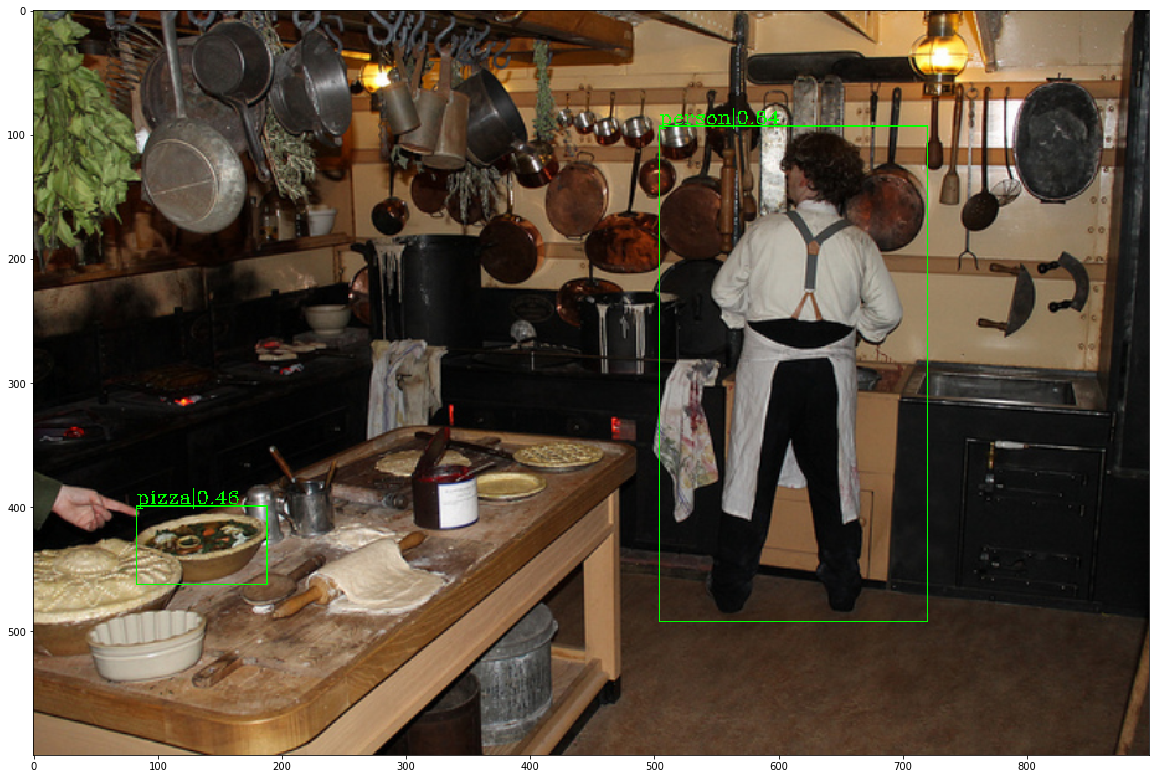

In [28]:
from src.visualization.show_result import get_result
"""
위 과정을 거친 결과를 보여드립니다.
"""

import matplotlib.pyplot as plt
img_results = get_result(sample, bbox_results[0], cfg.img_norm_cfg, 'coco')


plt.figure(figsize=(20, 20))
plt.imshow(img_results[0])